<a href="https://colab.research.google.com/github/CUAI4th-FinAI/2021-1-FinAl/blob/main/2021-1-FinAl/yamuzin-oksusu/0404_ch05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CH05 오차역전파법

계산 시간이 오래 걸린다는 수치 미분의 단점을 극복함<br> 
**가중치 매개 변수의 기울기를 효율적으로 계산 가능**<br>
계산 그래프 혹은 수식을 중심으로 이를 이해 할 수 있음

### 5.1 계산 그래프

계산 과정을 그래프로 나타냄

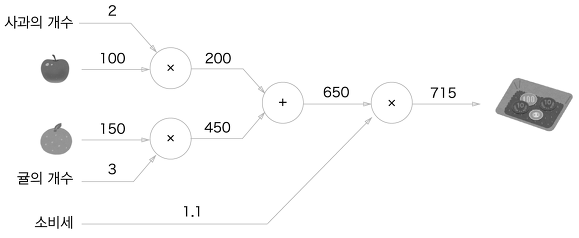

**순전파**? 계산 그래프의 출발점부터 종착점으로의 전파
**역전파**? 계산 그래프의 종착점부터 출발점으로의 전파 (미분 계산에 중요한 역할을 함) 

계산 그래프의 이점? 

1. **국소적 계산**<br>
전체가 아무리 복잡해도 각 노드에서는 단순한 계산에 집중하여 문제 해결 가능<br>
2. 중간 계산 결과를 모두 보관할 수 있음.
3. ** 역전파를 통해 '미분'을 효율적으로 계산할 수 있음**

### 5.2 연쇄법칙(chain rule)

- 원리 : 합성함수의 미분은 합성 함수를 구성하는 각 함수의 미분의 곱으로 나타낼 수 있다. 
- 역전파가 하는 일은 연쇄법칙의 원리와 같음<br>
 *역전파의 계산 절차에서는 노드로 들어온 입력 신호에 그 노드의 국소적 미분을 곱한 후 다음 노드로 전달*

### 5.3 역전파

덧셈노드의 역전파: 입력 신호를 다음 노드로 출력할 뿐이므로 출력값을 그대로 다음 노드(하류)로 전달

곱셈 노드의 역전파: 입력 신호를 바꾼 값을 곱함. (순전파의 입력 신호 유지)

### 5.4 단순한 계층 구현

#### 곱셈 계층(MulLayer)과 덧셈계층(AddLayer)

In [ ]:
#forward()는 순전파, backward()은 역전파 처리

class MulLayer:
    def __init__(self):  #인스턴트 변수인 x와 y를 초기화 (순전파 시의 입력값 유지)
        self.x = None
        self.y = None

    def forward(self, x, y):  #x와 y를 인수로 받고 두 값을 곱해서 반환
        self.x = x
        self.y = y                
        out = x * y

        return out

    def backward(self, dout):  # 상류에서 넘어온 미분에 순전파 때의 값을 '서로 바꿔'곱한 후 하류로 흘림
        dx = dout * self.y  # x와 y를 바꾼다.
        dy = dout * self.x

        return dx, dy


class AddLayer:
    def __init__(self):
        pass

    def forward(self, x, y):
        out = x + y

        return out

    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1

        return dx, dy

In [ ]:
apple = 100
apple_num = 2
tax = 1.1

mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

# backward
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print("price:", int(price))
print("dApple:", dapple)
print("dApple_num:", int(dapple_num))
print("dTax:", dtax)


price: 220
dApple: 2.2
dApple_num: 110
dTax: 200


In [ ]:
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# layer
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)  # (1)
orange_price = mul_orange_layer.forward(orange, orange_num)  # (2)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)  # (3)
price = mul_tax_layer.forward(all_price, tax)  # (4)

# backward
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)  # (4)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)  # (3)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)  # (2)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)  # (1)

print("price:", int(price))
print("dApple:", dapple)
print("dApple_num:", int(dapple_num))
print("dOrange:", dorange)
print("dOrange_num:", int(dorange_num))
print("dTax:", dtax)

price: 715
dApple: 2.2
dApple_num: 110
dOrange: 3.3000000000000003
dOrange_num: 165
dTax: 650


### 5.5 활성화 함수 계층 구현

- 순전파 때의 입력인 x가 0보다 크면 역전파는 상류의 값을 그대로 하류로 흘림.
- 순전파 떄 x가 0 이하면 역전파 때는 하류로 신호를 보내지 않음(0 보냄)

#### ReLu 계층

In [ ]:
class Relu:
    def __init__(self):
        self.mask = None  #mask: 인스턴스 변수. T/F로 구성된 넘파이 배열 0 이하는 T, 그 외는 F

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

In [ ]:
import numpy as np
x=np.array([[1.0,-0.5],[-2.0,3.0]])
print(x)
mask=(x<=0)
print(mask)

[[ 1.  -0.5]
 [-2.   3. ]]
[[False  True]
 [ True False]]


#### Sigmoid 계층

sigmoid 계층의 계산 그래프

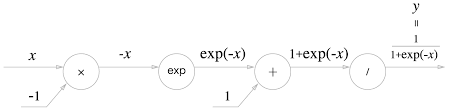

In [ ]:
class Sigmoid:  # 순전파의 출력을 인스턴스 변수 out에 보관했다가, 역전파때 그 변수를 사용해 계산 수행
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx

### 5.6 Affine/Softmax 계층 구현

#### Affine 계층과 배치용 Affine 계층

신경망의 순전파 때 수행하는 행렬의 내적은 기하학에서 **어파인 변환**이라고 함. <br>
어파인 계층? 어파인 변환을 수행하는 처리<br>
- 입력 데이터로 X 하나만을 고려

배치용 Affine계층? 데이터 N개를 묶어서 순전파 하는 경우
- 순전파의 편향 덧셈은 각각의 데이터에 더해짐. 
- 역전파 때는 각 데이터의 역전파 값이 편향의 원소에 모여야함.

In [ ]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 텐서 대응
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 입력 데이터 모양 변경(텐서 대응)
        return dx

#### Softmax-with-Loss 계층

소프트맥스 함수는 입력 값을 정규화(출력의 합이 1이 되도록 변경)하여 출력
- 신경망에서 수행하는 작업은 **학습**과 **추론** 두가지가 있음. 일반적으로 추론 시는 Softmax계층을 사용하지 않음. 신경망을 추론할 때는 마지막 Affine계층의 출력을 인식 결과로 이용함. 
- 신경망에서 정규화 하지 않는 출력결과를 점수(score)이라고 함. 신경망 추론에서 답을 하나만 내는 경우에는 가장 높은 점수만 알면 되니 Softmax계층은 필요 없지만 신경망을 학습할때는 Softmax 계층이 필요함

Softmax-with-Loss? 손실 함수인 교차 엔트로피 오차를 포함하는 개념


In [ ]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size  #전파하는 값을 배치의 수로 나눠서 데이터 1개당 오차를 앞 계층으로 전파
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

### 5.7 오차역전파법 구현


In [ ]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
#from common.layers import *
#from common.gradient import numerical_gradient
from collections import OrderedDict


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 가중치 초기화
        self.params = {} #신경망의 매개변수를 보관하는 딕셔너리변수
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size) #1번째 층의 가중치
        self.params['b1'] = np.zeros(hidden_size) #1번째 층의 편향
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

###################
#####계층 생성#####
################### 
        self.layers = OrderedDict() #순서가 있는 딕셔너리 변수로, 신경망의 계층을 보관
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
 # 각 계층을 순서대로 유지
        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

#4.5 학습 알고리즘 구현하기와 공통되는 부분이 많음. 계층을 사용한다는 점이 차이점이다

In [ ]:
import numpy as np


def identity_function(x):
    return x


def step_function(x):
    return np.array(x > 0, dtype=np.int)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))    


def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)
    

def relu(x):
    return np.maximum(0, x)


def relu_grad(x):
    grad = np.zeros(x)
    grad[x>=0] = 1
    return grad
    

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))


def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


def softmax_loss(X, t):
    y = softmax(X)
    return cross_entropy_error(y, t)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

def _numerical_gradient_no_batch(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x) # x와 형상이 같은 배열을 생성
    
    for idx in range(x.size):
        tmp_val = x[idx]
        
        # f(x+h) 계산
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)
        
        # f(x-h) 계산
        x[idx] = tmp_val - h 
        fxh2 = f(x) 
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val # 값 복원
        
    return grad
def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)
        
        return grad

In [ ]:
#기울기 확인_오차역전파법의 구현 검증
# 두 방식으로 구한 기울기가 일치함을 확인하는 작업

import matplotlib.pyplot as plt  # 그림으로 보기 위한 matplotlib 라이브러리 import
from tensorflow.keras.datasets import mnist  # 라이브러리가 기본으로 제공하는 mnist 데이터셋
from tensorflow.keras.utils import to_categorical  # one-hot encoding 을 위한 함수
from tensorflow.keras.models import Sequential  # 레이어를 층층히 쌓아가는 연쇄 모델
from tensorflow.keras.layers import Dense  # 완전연결층
from tensorflow.keras.models import load_model  # 저장된 모델 불러오기
(x_train,  t_train), (x_test, t_test) = mnist.load_data()

import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
#from dataset.mnist import load_mnist
#from two_layer_net import TwoLayerNet

# 데이터 읽기
#(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

# 각 가중치의 절대 오차의 평균을 구한다.
for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]) )
    print(key + ":" + str(diff))



W1:2.3780531648616902e-07
b1:6.525980362712949e-09
W2:2.8862980912364287e-06
b2:3.1159251607515424e-07


In [ ]:
#기울기를 오차역전파법으로구해 신경망 학습 구현

import sys, os
sys.path.append(os.pardir)

import numpy as np
#from dataset.mnist import load_mnist
#from two_layer_net import TwoLayerNet

# 데이터 읽기
#(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
(x_train,  t_train), (x_test, t_test) = mnist.load_data()
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch) # 수치 미분 방식
    grad = network.gradient(x_batch, t_batch) # 오차역전파법 방식(훨씬 빠르다)
    
    # 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)

0.09915 0.1009
0.1131 0.1141
0.1131 0.1141
0.1131 0.1141
0.1131 0.1141
0.1131 0.1141
0.1131 0.1141
0.1131 0.1141
0.1131 0.1141
0.1131 0.1141
0.1131 0.1141
0.1131 0.1141
0.1131 0.1141
0.1131 0.1141
0.10515 0.1034
0.1131 0.1141
0.1131 0.1141


### 5.8 정리

- 계산 그래프를 이용하면 계산 과정을 시각적으로 파악할 수 있다.
- 계산 그래프의 노드는 국소적 계산으로 구성된다. 국소적 계산을 조합해 전체 계산을 구성한다.
- 계산 그래프의 순전파는 통상의 계산을 수행한다. 한편, 계산 그래프의 역전파로는 각 노드의 미분을 구할 수 있다.
- 신경망의 구성 요소를 계층으로 구현하여 기울기를 효율적으로 계산할 수 있다(오차역전파법).
- 수치 미분과 오차역전파법의 결과를 비교하면 오차역전파법의 구현에 잘못이 없는지 확인할 수 있다(기울기 확인).